### Testing the logic of quantile

In [1]:
import numpy as np
n = 5
alpha = 0.1
cal_scrores = np.array([0.1,0.2,0.3,0.4,0.5])
q_level = np.ceil((n+1)*(1-alpha))/n
q_level = min(q_level, 1.0)                
print(q_level)
qhat = np.quantile(cal_scrores,q_level, method = 'higher')
print(qhat)
val_smx  = np.array([0.2,0.3,0.1,0.2,0.2])
predictions = val_smx >= (1-qhat)
print(predictions)

1.0
0.5
[False False False False False]


## Regression Model with Conformal Prediction

In [2]:
# loading a dataset from sklearn
from sklearn.datasets import load_diabetes
import pandas as pd
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
print(X.shape, y.shape)

# printing the first sample
print(X[0], y[0])
# Convert to DataFrame for easier exploration
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name="disease_progression")

print("Shape of features:", X.shape)
print("Shape of target:", y.shape)
print("\nColumns:", X.columns.tolist())
print("\nFirst 5 rows of features:\n", X.head())
print("\nFirst 5 target values:\n", y.head())
X = diabetes.data
y = diabetes.target


(442, 10) (442,)
[ 0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235  -0.03482076
 -0.04340085 -0.00259226  0.01990749 -0.01764613] 151.0
Shape of features: (442, 10)
Shape of target: (442,)

Columns: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

First 5 rows of features:
         age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  

First 5 target values:
 0    151.0
1     75

In [3]:
# splitting the dataset into three parts: training, calibration, and validation
from sklearn.model_selection import train_test_split
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # 20% for validation
X_train, X_cal, y_train, y_cal = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) # 20% of original data for calibration

print(X_train.shape, X_cal.shape, X_val.shape)
print(y_train.shape, y_cal.shape, y_val.shape)


(264, 10) (89, 10) (89, 10)
(264,) (89,) (89,)


In [4]:
# definign the regression model
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0, random_state=42)
# fitting the model to the training data
model.fit(X_train,y_train)

# predict a val set
y_pred = model.predict(X_val)
print("Output predicted --------")
print(y_pred[1])
print("True value --------------")
print(y_val[1])
print("the score is ", model.score(X_val,y_val))


Output predicted --------
157.97558783643512
True value --------------
70.0
the score is  0.3970847347463492


In [5]:
# printing the evaluations
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Evaluation
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Mean Squared Error: 3194.336566810981
Root Mean Squared Error: 56.518462176628454
R² Score: 0.3970847347463492


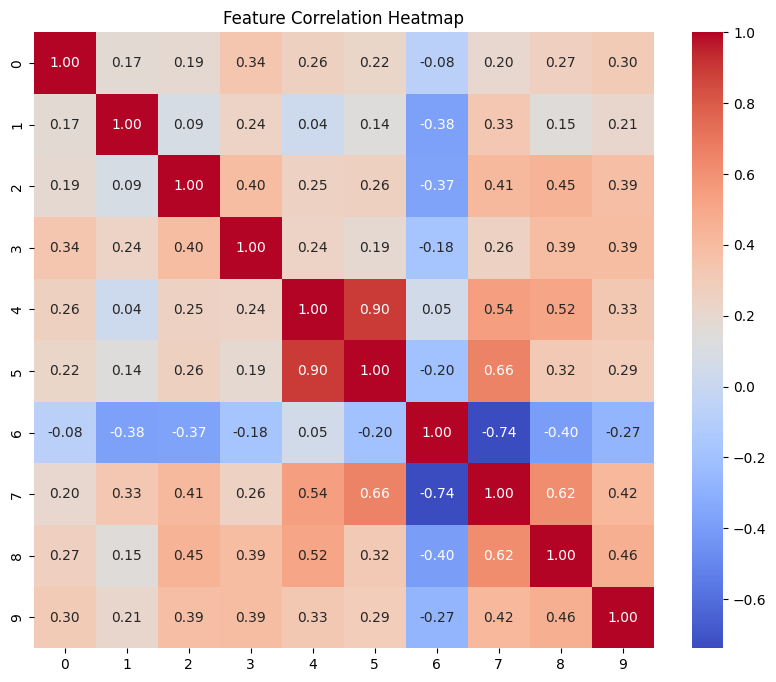

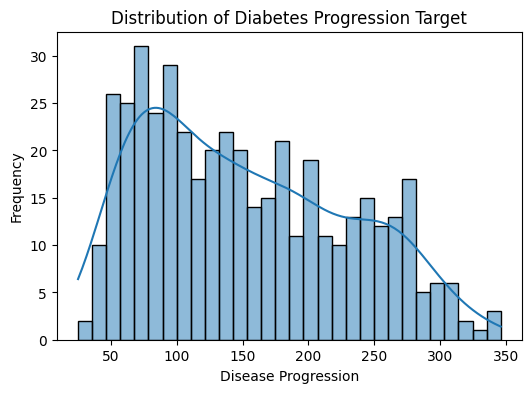

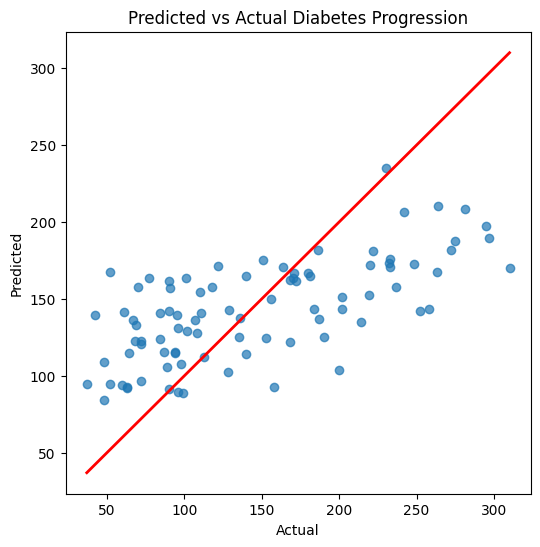

In [6]:
# plotting the predicted results
import matplotlib.pyplot as plt
import seaborn as sns
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(np.corrcoef(X, rowvar=False), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Distribution of target
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True, bins=30)
plt.title("Distribution of Diabetes Progression Target")
plt.xlabel("Disease Progression")
plt.ylabel("Frequency")
plt.show()

# Predicted vs Actual scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red", linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Diabetes Progression")
plt.show()

In [7]:
import numpy as np

# 1) Predictions on calibration set
cal_preds = model.predict(X_cal)

# 2) Nonconformity scores: absolute residuals
scores = np.abs(y_cal - cal_preds)

m = len(scores)
print("Number of calibration points:", m)
print("Scores summary: min =", scores.min(), "median =", np.median(scores), "max =", scores.max())



Number of calibration points: 89
Scores summary: min = 1.006152013048876 median = 46.51333742741926 max = 140.84302080166188


In [8]:
def conformal_regression_eval(model, X_cal, y_cal, X_val, y_val, alpha):
    """
    Given a trained model and a calibration/validation split,
    compute conformal intervals on the validation set for a given alpha.
    Returns (target_coverage, empirical_coverage, avg_width, q_hat).
    """
    # Predict on calibration
    cal_preds = model.predict(X_cal)
    scores = np.abs(y_cal - cal_preds)
    m = len(scores)

    # Finite-sample corrected quantile level
    q_level = np.ceil((m + 1) * (1 - alpha)) / m
    q_hat = np.quantile(scores, q_level)

    # Predict on validation set
    val_preds = model.predict(X_val)

    # Intervals
    L = val_preds - q_hat
    U = val_preds + q_hat

    # Coverage
    inside = (y_val >= L) & (y_val <= U)
    empirical_coverage = inside.mean()

    # Average width
    widths = U - L
    avg_width = widths.mean()

    target_coverage = 1 - alpha
    return target_coverage, empirical_coverage, avg_width, q_hat


In [9]:
alpha_list = [0.05, 0.1, 0.2]  # 95%, 90%, 80% nominal coverage
results = []

for alpha in alpha_list:
    target_cov, emp_cov, avg_width, q_hat = conformal_regression_eval(
        model, X_cal, y_cal, X_val, y_val, alpha
    )
    results.append((alpha, target_cov, emp_cov, avg_width, q_hat))

# Pretty print results
for alpha, target_cov, emp_cov, avg_width, q_hat in results:
    print(f"\nalpha = {alpha}")
    print(f"  Target coverage:    {target_cov:.3f}")
    print(f"  Empirical coverage: {emp_cov:.3f}")
    print(f"  Avg interval width: {avg_width:.3f}")
    print(f"  q_hat (radius):     {q_hat:.3f}")



alpha = 0.05
  Target coverage:    0.950
  Empirical coverage: 0.944
  Avg interval width: 203.760
  q_hat (radius):     101.880

alpha = 0.1
  Target coverage:    0.900
  Empirical coverage: 0.865
  Avg interval width: 173.669
  q_hat (radius):     86.835

alpha = 0.2
  Target coverage:    0.800
  Empirical coverage: 0.809
  Avg interval width: 144.987
  q_hat (radius):     72.494


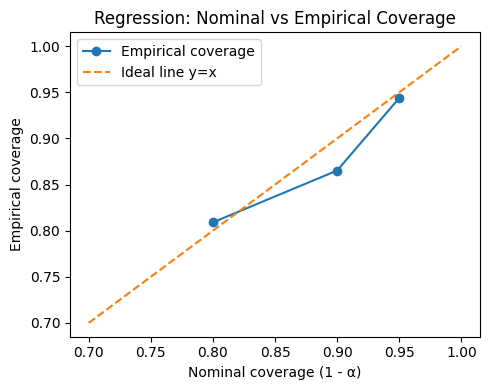

In [10]:
import matplotlib.pyplot as plt

nominal = [1 - a for a in alpha_list]
emp_covs = [r[2] for r in results]

plt.figure(figsize=(5,4))
plt.plot(nominal, emp_covs, marker="o", label="Empirical coverage")
plt.plot([0.7, 1.0], [0.7, 1.0], linestyle="--", label="Ideal line y=x")
plt.xlabel("Nominal coverage (1 - α)")
plt.ylabel("Empirical coverage")
plt.title("Regression: Nominal vs Empirical Coverage")
plt.legend()
plt.tight_layout()
plt.show()


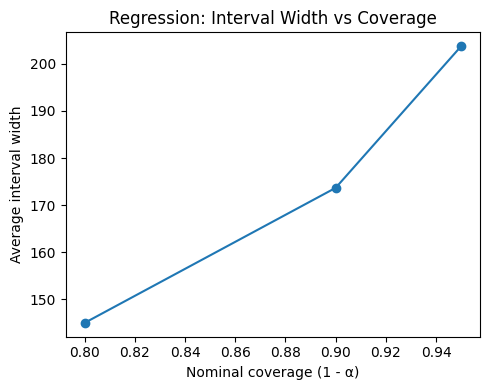

In [11]:
avg_widths = [r[3] for r in results]

plt.figure(figsize=(5,4))
plt.plot(nominal, avg_widths, marker="o")
plt.xlabel("Nominal coverage (1 - α)")
plt.ylabel("Average interval width")
plt.title("Regression: Interval Width vs Coverage")
plt.tight_layout()
plt.show()


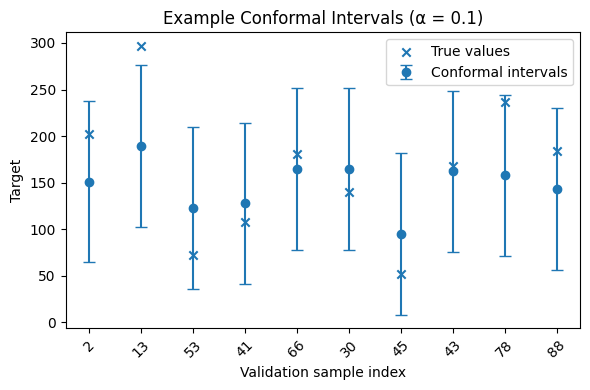

In [12]:
# Reuse a single alpha (say 0.1)
_, _, _, q_hat_01 = conformal_regression_eval(model, X_cal, y_cal, X_val, y_val, alpha=0.1)
val_preds = model.predict(X_val)

L = val_preds - q_hat_01
U = val_preds + q_hat_01

rng = np.random.RandomState(0)
idx = rng.choice(len(y_val), size=10, replace=False)
x_axis = np.arange(len(idx))

plt.figure(figsize=(6,4))
plt.errorbar(
    x_axis,
    val_preds[idx],
    yerr=[val_preds[idx] - L[idx], U[idx] - val_preds[idx]],
    fmt="o",
    capsize=4,
    label="Conformal intervals"
)
plt.scatter(x_axis, y_val[idx], marker="x", label="True values")
plt.xticks(x_axis, [str(i) for i in idx], rotation=45)
plt.xlabel("Validation sample index")
plt.ylabel("Target")
plt.title("Example Conformal Intervals (α = 0.1)")
plt.legend()
plt.tight_layout()
plt.show()


## Classification Model with Conformal Prediction

In [13]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Load classification dataset
X_cls, y_cls = load_breast_cancer(return_X_y=True)

# Train / calibration / validation split
X_temp_c, X_val_c, y_temp_c, y_val_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

X_train_c, X_cal_c, y_train_c, y_cal_c = train_test_split(
    X_temp_c, y_temp_c, test_size=0.25, random_state=42, stratify=y_temp_c
)
# (same 60/20/20 logic as regression)

print("Train:", X_train_c.shape, "Cal:", X_cal_c.shape, "Val:", X_val_c.shape)

# Base classifier
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
clf.fit(X_train_c, y_train_c)

# Baseline accuracy on validation set (no conformal yet)
y_val_pred_point = clf.predict(X_val_c)
base_acc = accuracy_score(y_val_c, y_val_pred_point)
print("Baseline point accuracy on validation:", base_acc)


Train: (341, 30) Cal: (114, 30) Val: (114, 30)
Baseline point accuracy on validation: 0.9473684210526315
